# EDA 및 모델 선정 실험 (v2)

이 노트북은 사운드 데이터에 대한 EDA(탐색적 데이터 분석)를 수행하고, 여러 모델의 성능을 비교하여 최적의 모델을 선정하기 위한 실험을 진행합니다.

## 1. 의존성 설치 및 임포트

In [4]:
# !pip install numpy pandas librosa matplotlib seaborn > /dev/null
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

DATA_DIR = ".."
# 프로젝트 데이터 폴더의 실제 클래스(한글 폴더명)로 업데이트함
CLASSES = [
    "가전제품_종료",
    "개",
    "문_노크",
    "문_도어락",
    "문_초인종",
    "배경소음",
    "소음_가구",
    "소음_드럼",
    "소음_문소리",
    "소음_아이발소리",
    "소음_어른발소리",
    "소음_청소기",
    "소음_통돌이",
    "아기_울음",
    "안전_낙상",
    "안전_화재_경보",
    "정적",
    "타이머_알람",
    "폰_링톤",
    "폰_알림",
    "폰_전화",
]

# 한글 폰트 설정 (macOS)
sns.set_theme(style="whitegrid", font="AppleGothic")
plt.rcParams["axes.unicode_minus"] = False

## 2. 데이터 불러오기 및 클래스 분포 확인

총 파일 개수: 1203
  - Train: 858
  - Test: 345

클래스별 데이터 분포:
split     test  train  Total
label                       
가전제품_종료      3     10     13
개            5     20     25
문_노크        12     32     44
문_도어락        5     18     23
문_초인종        9     23     32
배경소음         8     27     35
소음_가구       18     36     54
소음_드럼       15     60     75
소음_문소리      15     40     55
소음_아이발소리    21     71     92
소음_어른발소리    18     53     71
소음_청소기      10     32     42
소음_통돌이      10     62     72
아기_울음       32    128    160
안전_낙상       21     80    101
안전_화재_경보     6     21     27
정적           6     17     23
타이머_알람       4      7     11
폰_링톤        40     34     74
폰_알림        72     72    144
폰_전화        15     15     30


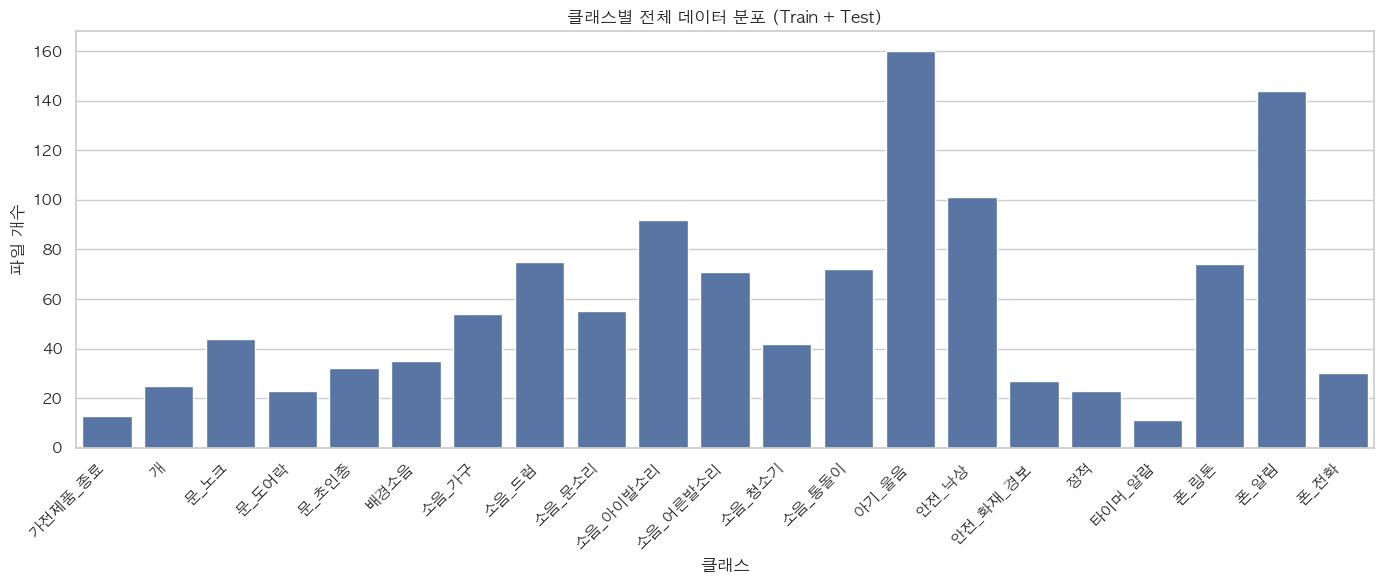

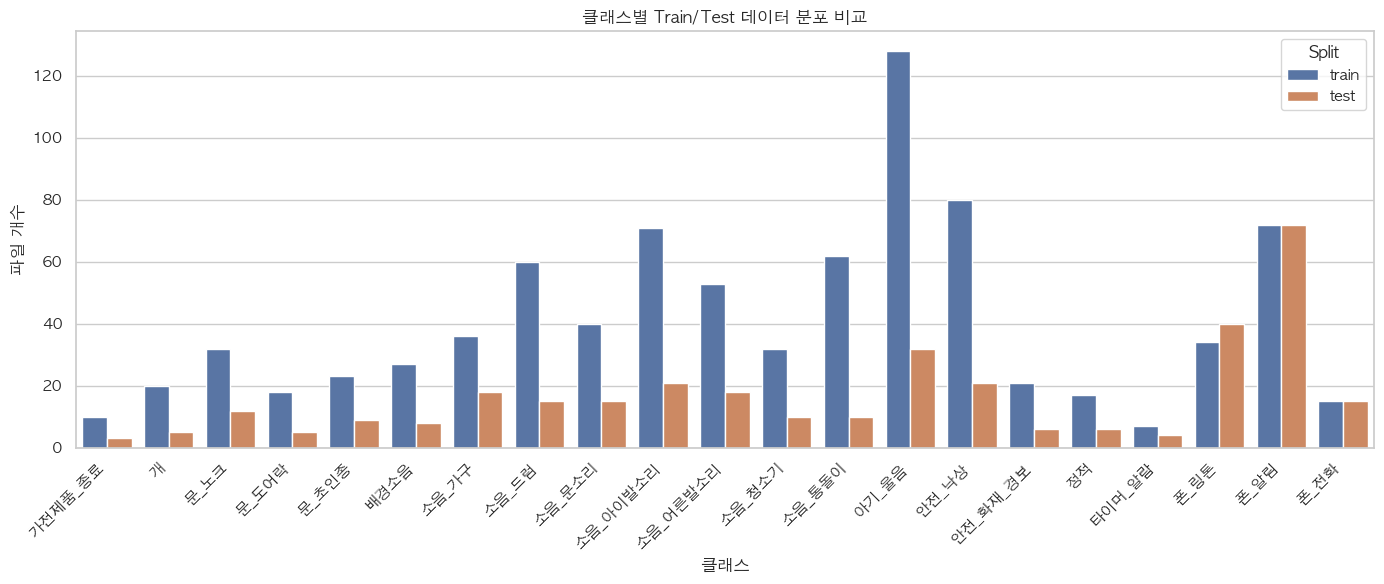

In [5]:
def load_filepaths(data_dir, split=None):
    # 한글 파일명 정규화 문제를 방지하기 위해 NFC로 정규화하여 비교함
    norm_classes = set(unicodedata.normalize('NFC', c) for c in CLASSES)
    filepaths = []
    labels = []
    splits_to_load = [split] if split else ["train", "test"]
    
    # train과 test 폴더를 모두 포함하도록 변경 (사용자 요청: 트레인+테스트 합쳐서 사용)
    for s in splits_to_load:
        split_dir = os.path.join(data_dir, s)
        if not os.path.exists(split_dir): continue
        for class_name in os.listdir(split_dir):
            n_class = unicodedata.normalize('NFC', class_name)
            if n_class in norm_classes:
                class_dir = os.path.join(split_dir, class_name)
                if not os.path.isdir(class_dir): continue
                for filename in os.listdir(class_dir):
                    filepath = os.path.join(class_dir, filename)
                    filepaths.append(filepath)
                    labels.append(n_class)
    return pd.DataFrame({'filepath': filepaths, 'label': labels, 'split': splits_to_load[0] if split else 'combined'})

# 각 폴더별로 데이터 로드
df_train = load_filepaths(DATA_DIR, split="train")
df_test = load_filepaths(DATA_DIR, split="test")
df_train['split'] = 'train'
df_test['split'] = 'test'

# 전체 데이터 병합
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"총 파일 개수: {len(df)}")
print(f"  - Train: {len(df_train)}")
print(f"  - Test: {len(df_test)}")
print()

# 클래스별 train/test 분포 출력
print("클래스별 데이터 분포:")
class_split = df.groupby(['label', 'split']).size().unstack(fill_value=0)
class_split['Total'] = class_split.sum(axis=1)
print(class_split)

# 클래스별 데이터 분포 시각화 (레이블 기울임)
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(data=df, x='label', order=CLASSES, ax=ax)
plt.title('클래스별 전체 데이터 분포 (Train + Test)')
plt.xlabel('클래스')
plt.ylabel('파일 개수')
plt.xticks(rotation=45, ha='right')  # 레이블을 45도로 기울임
plt.tight_layout()
plt.show()

# Train vs Test 비교 시각화
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(data=df, x='label', hue='split', order=CLASSES, ax=ax)
plt.title('클래스별 Train/Test 데이터 분포 비교')
plt.xlabel('클래스')
plt.ylabel('파일 개수')
plt.xticks(rotation=45, ha='right')  # 레이블을 45도로 기울임
plt.legend(title='Split')
plt.tight_layout()
plt.show()

## 3. 오디오 길이 분석

/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm

/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm

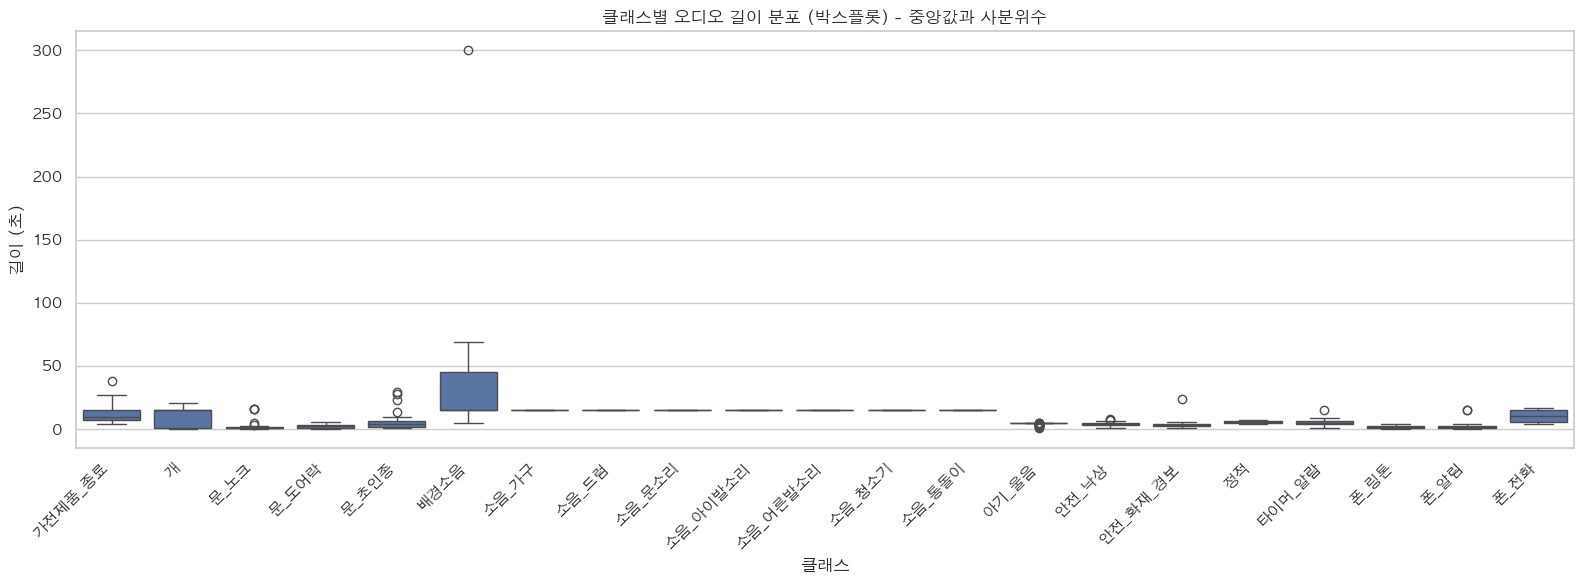

/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm

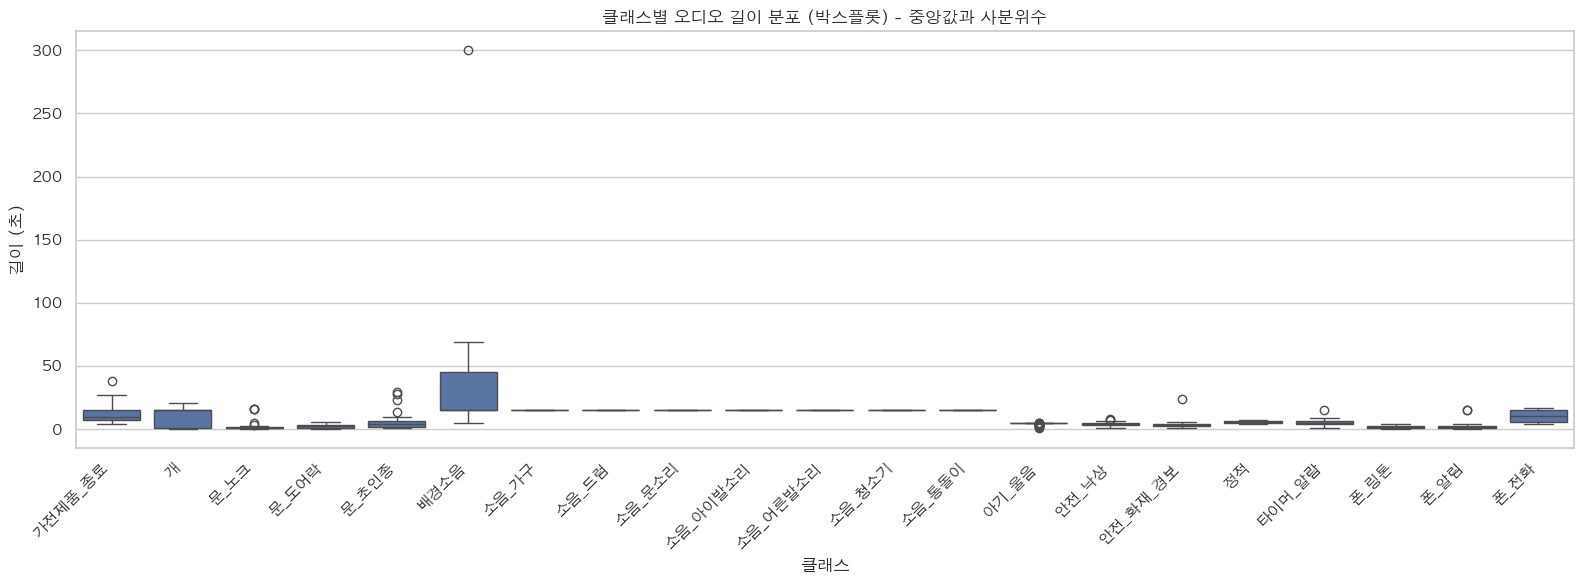

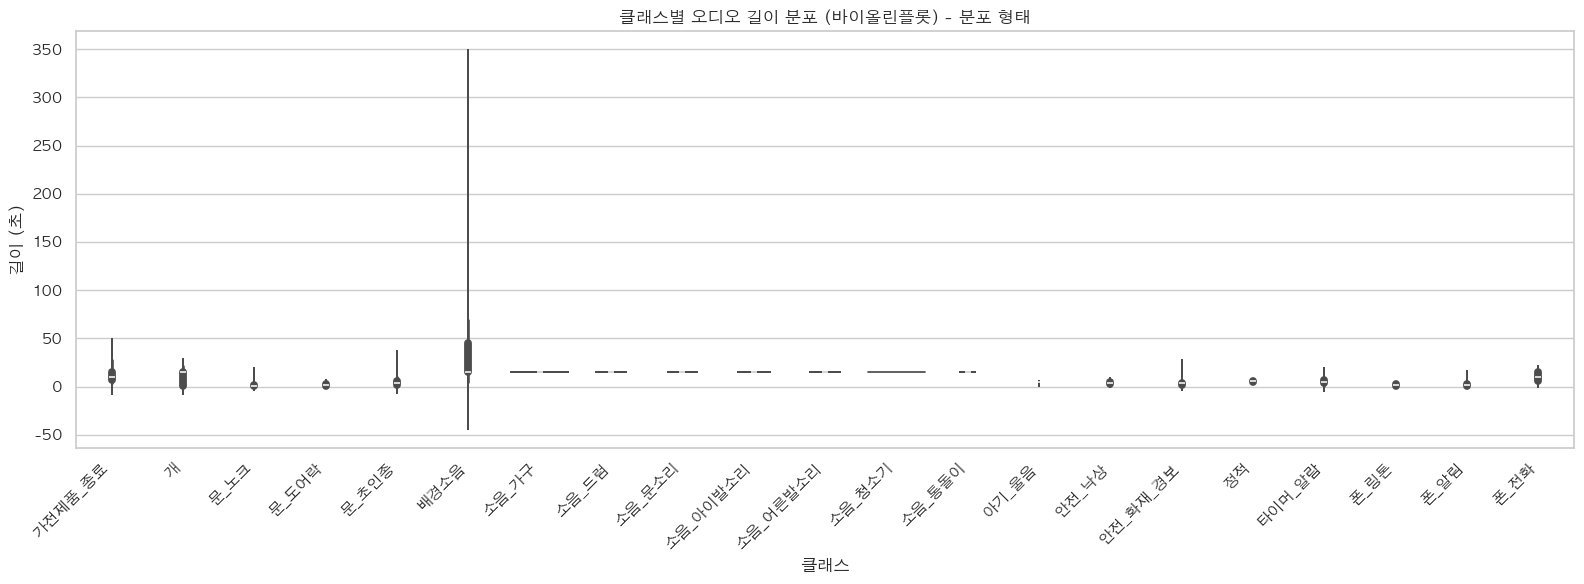

/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm0000gn/T/ipykernel_6251/364223562.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=None)
/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/9g/jc575gcs03ldzjf4y_2nmltm

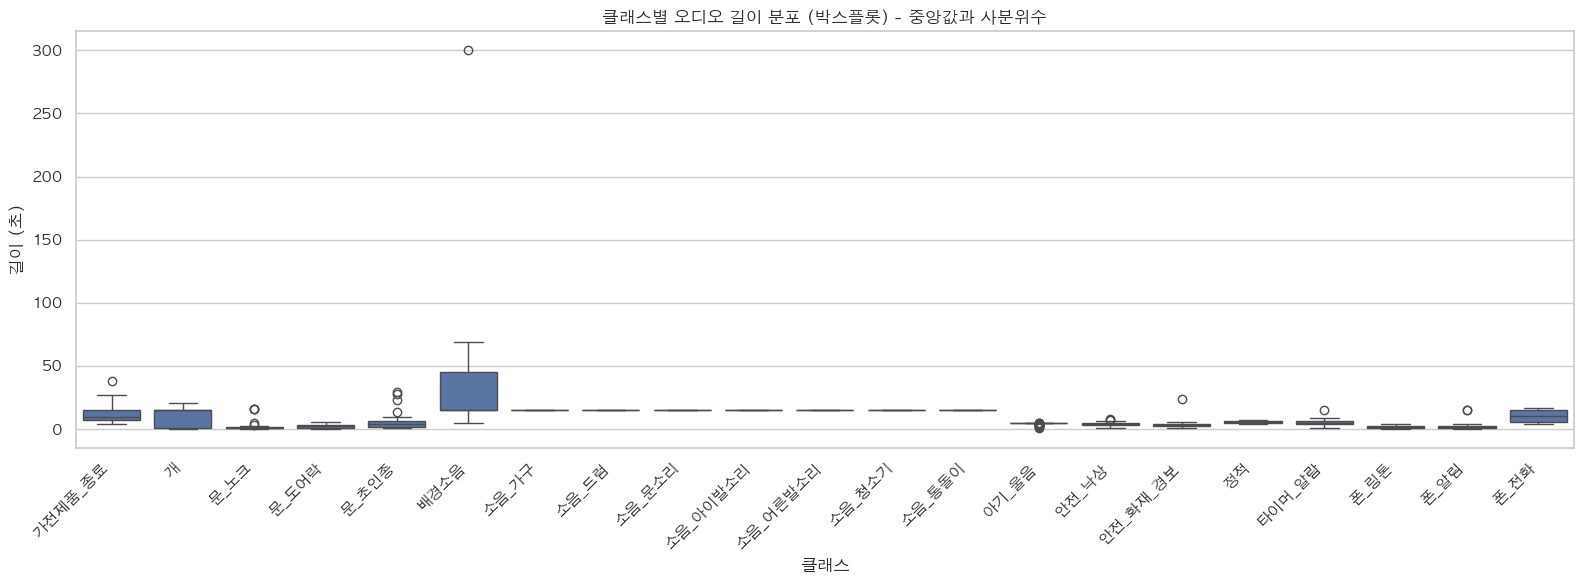

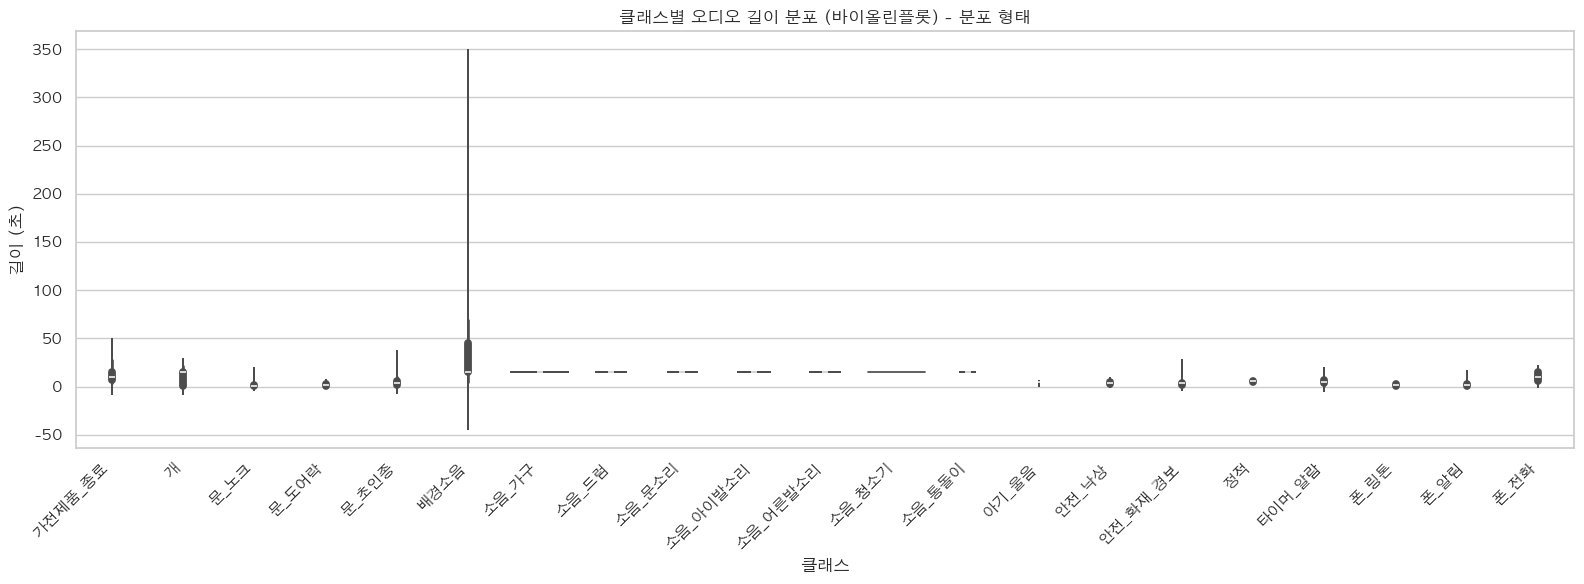

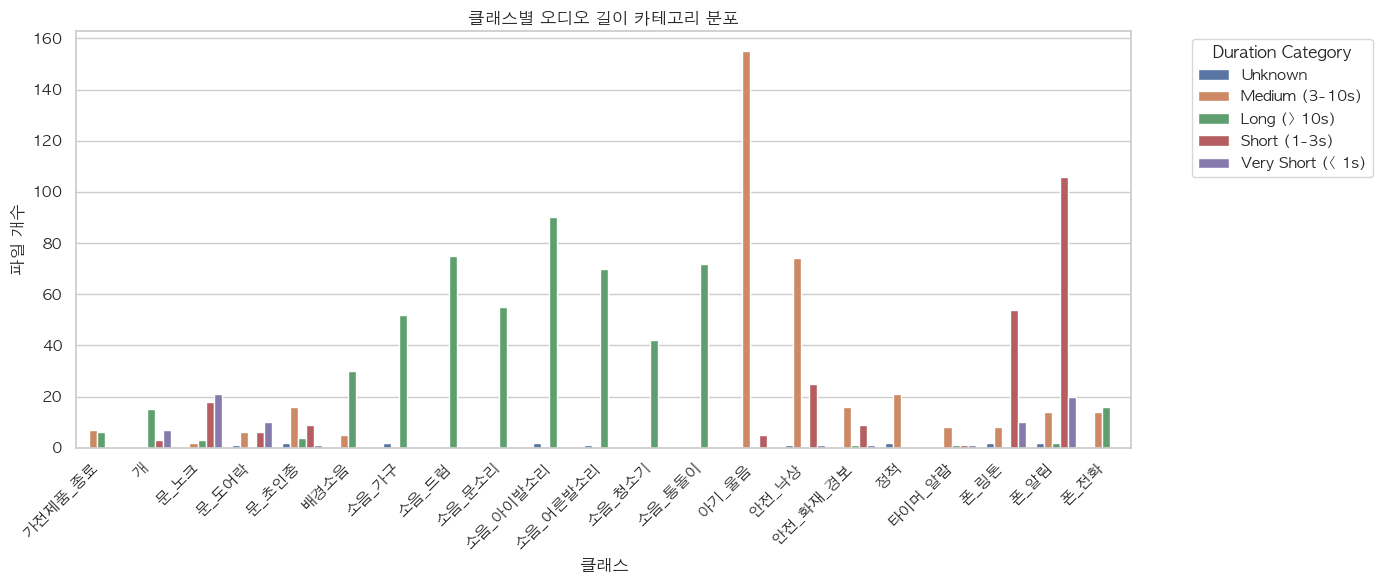

클래스별 오디오 길이 통계:
          count       mean        std        min        25%        50%  \
label                                                                    
가전제품_종료    13.0  12.996955   9.647727   4.065042   6.816000   9.864014   
개          25.0   9.542400   7.430254   0.160000   0.960000  15.000000   
문_노크       44.0   2.190511   3.751734   0.280000   0.670000   1.101825   
문_도어락      22.0   2.112049   1.649461   0.400000   0.580000   2.100635   
문_초인종      30.0   6.407304   7.450996   0.960000   1.720000   3.981633   
배경소음       35.0  35.456341  49.743167   5.041633  15.000000  15.168005   
소음_가구      52.0  15.000000   0.000000  15.000000  15.000000  15.000000   
소음_드럼      75.0  15.000000   0.000000  15.000000  15.000000  15.000000   
소음_문소리     55.0  15.000000   0.000000  15.000000  15.000000  15.000000   
소음_아이발소리   90.0  15.000000   0.000000  15.000000  15.000000  15.000000   
소음_어른발소리   70.0  15.000000   0.000000  15.000000  15.000000  15.000000   
소음_청소기     42.0  15.00

In [7]:
def get_audio_length(filepath):
    try:
        y, sr = librosa.load(filepath, sr=None)
        return len(y) / sr
    except Exception as e:
        return None

df['length'] = df['filepath'].apply(get_audio_length)

# ============ 최적화 방안 1: 박스플롯 ============
# 클래스별 길이 분포를 박스플롯으로 표시 (중앙값, 사분위수, 이상치 시각화)
fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(data=df, x='label', y='length', order=CLASSES, ax=ax)
plt.title('클래스별 오디오 길이 분포 (박스플롯) - 중앙값과 사분위수')
plt.xlabel('클래스')
plt.ylabel('길이 (초)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============ 최적화 방안 2: 바이올린플롯 ============
# 길이 분포의 형태(밀도)를 상세히 표시
fig, ax = plt.subplots(figsize=(16, 6))
sns.violinplot(data=df, x='label', y='length', order=CLASSES, ax=ax)
plt.title('클래스별 오디오 길이 분포 (바이올린플롯) - 분포 형태')
plt.xlabel('클래스')
plt.ylabel('길이 (초)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============ 최적화 방안 3: 길이 범위 카테고리화 ============
# 음성을 길이별로 분류 (너무 짧거나 긴 음성 파악)
def categorize_length(length):
    if pd.isna(length):
        return 'Unknown'
    elif length < 1:
        return 'Very Short (< 1s)'
    elif length < 3:
        return 'Short (1-3s)'
    elif length < 10:
        return 'Medium (3-10s)'
    else:
        return 'Long (> 10s)'

df['length_category'] = df['length'].apply(categorize_length)

# 길이 카테고리별 분포
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(data=df, x='label', hue='length_category', order=CLASSES, ax=ax)
plt.title('클래스별 오디오 길이 카테고리 분포')
plt.xlabel('클래스')
plt.ylabel('파일 개수')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Duration Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ============ 통계 요약 ============
print("=" * 80)
print("클래스별 오디오 길이 통계:")
print("=" * 80)
length_stats = df.groupby('label')['length'].describe()
print(length_stats)

print("\n" + "=" * 80)
print("길이 카테고리별 분포:")
print("=" * 80)
category_dist = df.groupby(['label', 'length_category']).size().unstack(fill_value=0)
print(category_dist)

print("\n" + "=" * 80)
print("길이 범위 요약:")
print("=" * 80)
print(f"최단: {df['length'].min():.2f}초")
print(f"최장: {df['length'].max():.2f}초")
print(f"평균: {df['length'].mean():.2f}초")
print(f"중앙값: {df['length'].median():.2f}초")
print(f"표준편차: {df['length'].std():.2f}초")

## 4. 파형 및 스펙트로그램 시각화

In [15]:

def visualize_sample(df, class_name, save_dir='sample_images'):
    # 클래스에 해당하는 임의의 샘플 1개 추출
    sample_path = df[df['label'] == class_name].sample(1).iloc[0]['filepath']
    
    # 오디오 로드
    y, sr = librosa.load(sample_path, sr=16000)
    
    # 폴더 없으면 생성
    os.makedirs(save_dir, exist_ok=True)
    
    # 시각화
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    
    # 1. Waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title(f'{class_name} 샘플 파형 (Waveform)')
    
    # 2. Log-Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=axs[1])
    axs[1].set_title(f'{class_name} 샘플 로그-멜 스펙트로그램 (Log-Mel Spectrogram)')
    
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
    fig.tight_layout()
    
    # 파일로 저장
    save_path = os.path.join(save_dir, f"{class_name}_sample.png")
    plt.savefig(save_path)
    plt.close(fig)
    
    print(f"✅ {class_name} 시각화 이미지 저장 완료 → {save_path}")

# 예시 실행
for c in CLASSES:
    visualize_sample(df, c)

파형 및 스펙트로그램 시각화 시작 (21개 클래스)
[ 1/21] ✅ 가전제품_종료
[ 1/21] ✅ 가전제품_종료
[ 2/21] ✅ 개
[ 2/21] ✅ 개
[ 3/21] ✅ 문_노크
[ 3/21] ✅ 문_노크
[ 4/21] ✅ 문_도어락
[ 4/21] ✅ 문_도어락
[ 5/21] ✅ 문_초인종
[ 5/21] ✅ 문_초인종
[ 6/21] ✅ 배경소음
[ 6/21] ✅ 배경소음
[ 7/21] ✅ 소음_가구
[ 7/21] ✅ 소음_가구
[ 8/21] ✅ 소음_드럼
[ 8/21] ✅ 소음_드럼
[ 9/21] ✅ 소음_문소리
[ 9/21] ✅ 소음_문소리
[10/21] ✅ 소음_아이발소리
[10/21] ✅ 소음_아이발소리
[11/21] ✅ 소음_어른발소리
[11/21] ✅ 소음_어른발소리
[12/21] ✅ 소음_청소기
[12/21] ✅ 소음_청소기
[13/21] ✅ 소음_통돌이
[13/21] ✅ 소음_통돌이
[14/21] ✅ 아기_울음
[14/21] ✅ 아기_울음
[15/21] ✅ 안전_낙상
[15/21] ✅ 안전_낙상
[16/21] ✅ 안전_화재_경보
[16/21] ✅ 안전_화재_경보
[17/21] ✅ 정적
[17/21] ✅ 정적
[18/21] ✅ 타이머_알람
[18/21] ✅ 타이머_알람
[19/21] ✅ 폰_링톤
[19/21] ✅ 폰_링톤
[20/21] ✅ 폰_알림
[20/21] ✅ 폰_알림
[21/21] ✅ 폰_전화
완료: 21/21 클래스 시각화 저장됨
저장 위치: ./sample_images/
[21/21] ✅ 폰_전화
완료: 21/21 클래스 시각화 저장됨
저장 위치: ./sample_images/


## 5. 모델 성능 비교 실험

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 전처리된 데이터 로드 (soundlight_mvp.ipynb의 전처리 파트 실행 필요)
try:
    X_train = np.load('../cache/X_train.npy')
    y_train = np.load('../cache/y_train.npy')
    X_val = np.load('../cache/X_val.npy')
    y_val = np.load('../cache/y_val.npy')
    # 3-channel로 복제 (전이학습 모델 인풋에 맞춤)
    X_train = np.repeat(X_train, 3, axis=-1)
    X_val = np.repeat(X_val, 3, axis=-1)
    print('전처리된 데이터셋을 성공적으로 불러왔습니다.')
    print(f'Train set: {X_train.shape}, {y_train.shape}')
    print(f'Validation set: {X_val.shape}, {y_val.shape}')
except FileNotFoundError:
    print('[오류] 전처리된 데이터를 찾을 수 없습니다.')
    print('먼저 soundlight_mvp.ipynb 노트북의 전처리 셀을 실행하여 cache/X_train.npy 등의 파일을 생성해주세요.')

전처리된 데이터셋을 성공적으로 불러왔습니다.
Train set: (1895, 128, 128, 3), (1895,)
Validation set: (449, 128, 128, 3), (449,)


In [13]:
if 'X_train' in locals():
    NUM_CLASSES = len(CLASSES)
    INPUT_SHAPE = X_train.shape[1:]

    def build_custom_cnn(input_shape, num_classes):
        model = models.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_transfer_model(base_model_fn, input_shape, num_classes):
        # weights='imagenet' 제거 - 1채널 입력과 호환되지 않으므로 랜덤 초기화 사용
        base_model = base_model_fn(input_shape=input_shape, include_top=False, weights=None)
        base_model.trainable = False
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    models_to_test = {
        'Custom CNN': build_custom_cnn(INPUT_SHAPE, NUM_CLASSES),
        'MobileNetV2': build_transfer_model(tf.keras.applications.MobileNetV2, INPUT_SHAPE, NUM_CLASSES),
        'EfficientNetB0': build_transfer_model(tf.keras.applications.EfficientNetB0, INPUT_SHAPE, NUM_CLASSES)
    }

    histories = {}
    EPOCHS = 10 # 빠른 비교를 위해 epoch 수를 줄여서 실험

    for name, model in models_to_test.items():
        print(f'--- {name} 모델 학습 시작 ---')
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=32, verbose=1)
        histories[name] = history.history
        print(f'--- {name} 모델 학습 완료 ---')

/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/opt/anaconda3/envs/abc-bootcamp-FP-2025/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Custom CNN 모델 학습 시작 ---
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7620 - loss: 5.1420 - val_accuracy: 0.8463 - val_loss: 0.7290
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7620 - loss: 5.1420 - val_accuracy: 0.8463 - val_loss: 0.7290
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9203 - loss: 0.2167 - val_accuracy: 0.8486 - val_loss: 0.7440
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9203 - loss: 0.2167 - val_accuracy: 0.8486 - val_loss: 0.7440
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9551 - loss: 0.1269 - val_accuracy: 0.8552 - val_loss: 0.8627
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9551 - loss: 0.1269 - val_accuracy: 0.8552 - val_loss: 0.8627
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9726 - loss: 0.0917 - val_accuracy: 0.8641 - val_loss: 0.8863
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9726 - loss: 0.091

## 6. 실험 결과 요약

모델 성능 비교 분석


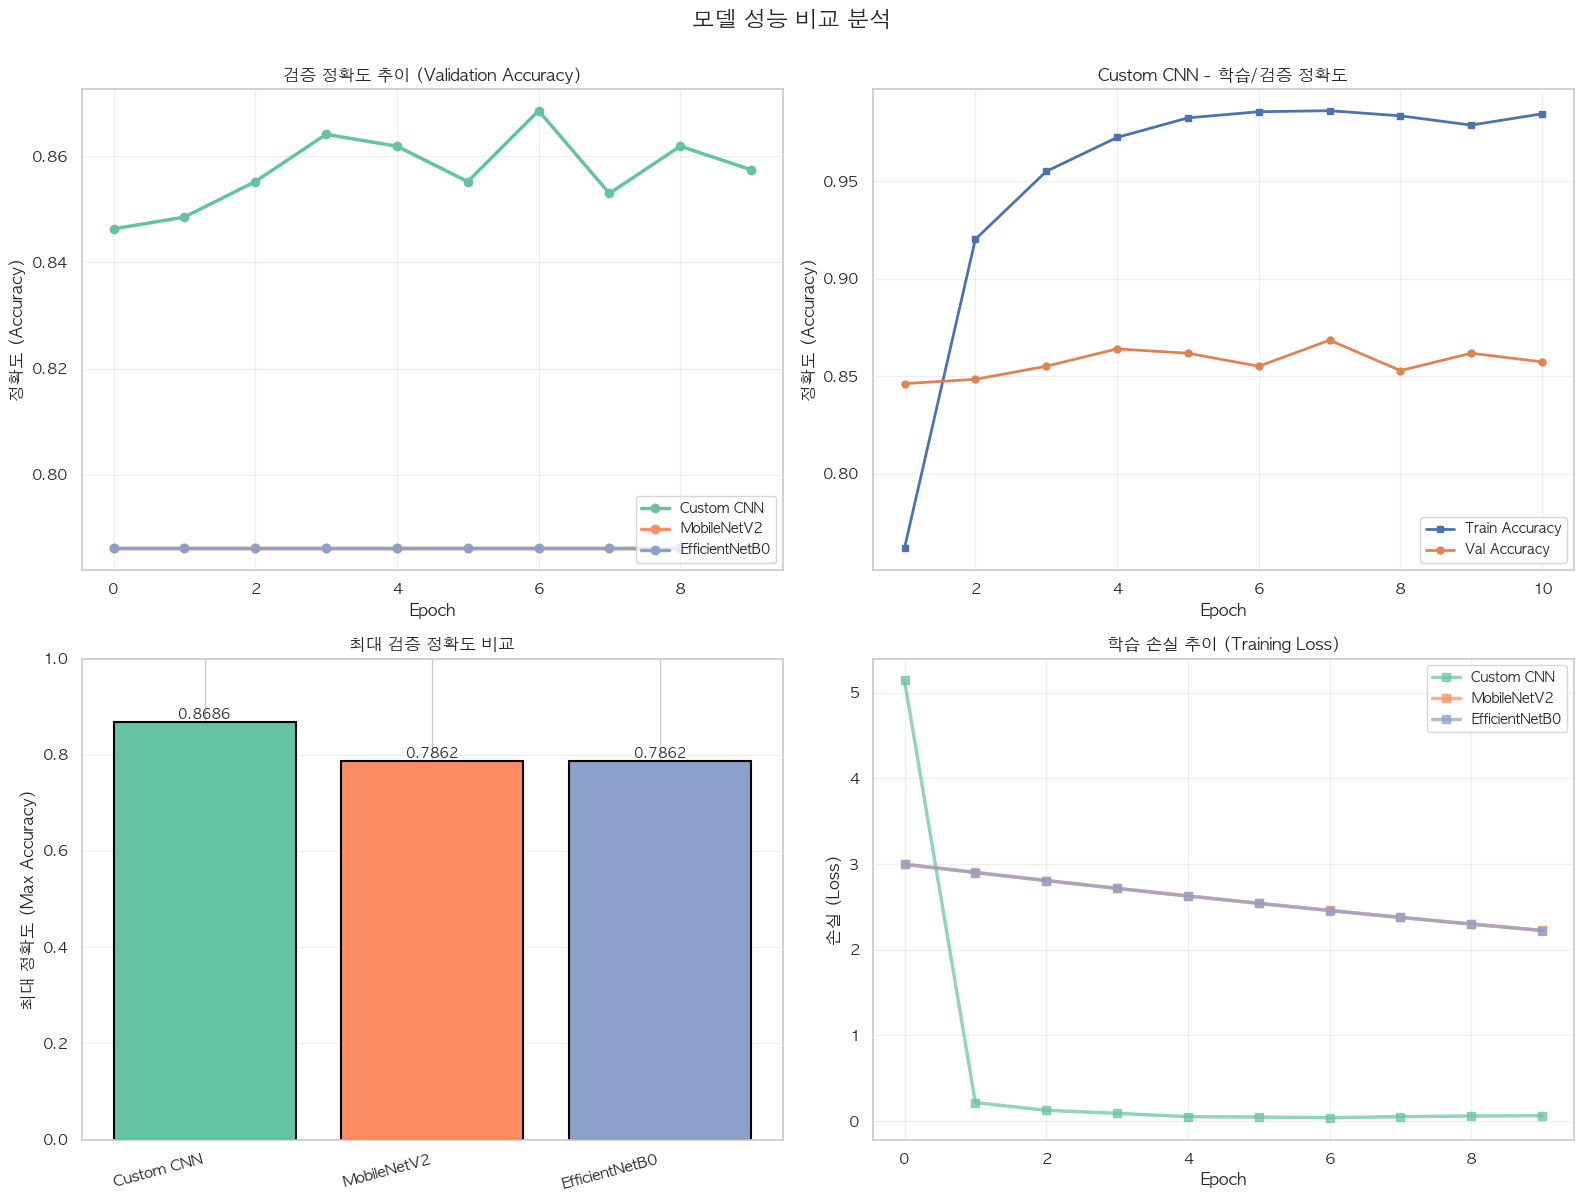


모델별 성능 요약
               최종 학습 정확도 최종 검증 정확도 최대 검증 정확도   최소 손실   최종 손실   과적합 정도
Custom CNN        0.9847    0.8575    0.8686  0.0400  0.0643   0.1177
MobileNetV2       0.7193    0.7862    0.7862  2.2252  2.2252  -0.0669
EfficientNetB0    0.7193    0.7862    0.7862  2.2241  2.2241  -0.0669

모델 선정 결과

🏆 최고 성능 모델: Custom CNN
   최대 검증 정확도: 0.8686 (86.86%)

--------------------------------------------------------------------------------
모델별 상세 분석
--------------------------------------------------------------------------------

[1] Custom CNN
    최종 학습 정확도: 0.9847
    최종 검증 정확도: 0.8575
    최대 검증 정확도: 0.8686 ← 주요 지표
    과적합 정도: 0.1177 (낮을수록 좋음)
    최소 손실: 0.0400

[2] MobileNetV2
    최종 학습 정확도: 0.7193
    최종 검증 정확도: 0.7862
    최대 검증 정확도: 0.7862 ← 주요 지표
    과적합 정도: -0.0669 (낮을수록 좋음)
    최소 손실: 2.2252

[3] EfficientNetB0
    최종 학습 정확도: 0.7193
    최종 검증 정확도: 0.7862
    최대 검증 정확도: 0.7862 ← 주요 지표
    과적합 정도: -0.0669 (낮을수록 좋음)
    최소 손실: 2.2241

분석 완료 - 모델 비교 시각화: model_comparison_analysis.png


In [16]:
if 'histories' in locals():
    print("=" * 80)
    print("모델 성능 비교 분석")
    print("=" * 80)
    
    # 1. 검증 정확도 비교 (라인 플롯)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('모델 성능 비교 분석', fontsize=16, fontweight='bold', y=1.00)
    
    # ===== 1-1. 검증 정확도 비교 (라인 플롯) =====
    ax = axes[0, 0]
    colors = plt.cm.Set2(range(len(histories)))
    for (name, history), color in zip(histories.items(), colors):
        ax.plot(history['val_accuracy'], label=f'{name}', marker='o', linewidth=2.5, markersize=6, color=color)
    ax.set_title('검증 정확도 추이 (Validation Accuracy)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('정확도 (Accuracy)')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ===== 1-2. 학습 정확도 vs 검증 정확도 비교 (첫 번째 모델) =====
    ax = axes[0, 1]
    first_model_name = list(histories.keys())[0]
    first_history = histories[first_model_name]
    epochs_range = range(1, len(first_history['val_accuracy']) + 1)
    ax.plot(epochs_range, first_history['accuracy'], label='Train Accuracy', marker='s', linewidth=2, markersize=5)
    ax.plot(epochs_range, first_history['val_accuracy'], label='Val Accuracy', marker='o', linewidth=2, markersize=5)
    ax.set_title(f'{first_model_name} - 학습/검증 정확도', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('정확도 (Accuracy)')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ===== 1-3. 최대 검증 정확도 비교 (막대 차트) =====
    ax = axes[1, 0]
    model_names = list(histories.keys())
    max_accuracies = [max(histories[name]['val_accuracy']) for name in model_names]
    bars = ax.bar(model_names, max_accuracies, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_title('최대 검증 정확도 비교', fontsize=12, fontweight='bold')
    ax.set_ylabel('최대 정확도 (Max Accuracy)')
    ax.set_ylim([0, 1.0])
    # 각 막대 위에 정확도 값 표시
    for bar, acc in zip(bars, max_accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # ===== 1-4. 학습 손실(Loss) 비교 =====
    ax = axes[1, 1]
    for (name, history), color in zip(histories.items(), colors):
        ax.plot(history['loss'], label=f'{name}', marker='s', linewidth=2.5, markersize=6, color=color, alpha=0.7)
    ax.set_title('학습 손실 추이 (Training Loss)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('손실 (Loss)')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_comparison_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. 성능 요약 테이블 생성
    print("\n" + "=" * 80)
    print("모델별 성능 요약")
    print("=" * 80)
    
    summary = pd.DataFrame()
    for name, history in histories.items():
        summary.loc[name, '최종 학습 정확도'] = f"{history['accuracy'][-1]:.4f}"
        summary.loc[name, '최종 검증 정확도'] = f"{history['val_accuracy'][-1]:.4f}"
        summary.loc[name, '최대 검증 정확도'] = f"{max(history['val_accuracy']):.4f}"
        summary.loc[name, '최소 손실'] = f"{min(history['loss']):.4f}"
        summary.loc[name, '최종 손실'] = f"{history['loss'][-1]:.4f}"
        # 과적합 정도 계산 (높을수록 과적합)
        overfitting = max(history['accuracy']) - max(history['val_accuracy'])
        summary.loc[name, '과적합 정도'] = f"{overfitting:.4f}"
    
    summary_sorted = summary.sort_values('최대 검증 정확도', ascending=False)
    print(summary_sorted)
    
    # 3. 최고 성능 모델 선정
    print("\n" + "=" * 80)
    print("모델 선정 결과")
    print("=" * 80)
    best_model = summary_sorted.index[0]
    best_accuracy = float(summary_sorted.iloc[0]['최대 검증 정확도'])
    print(f"\n🏆 최고 성능 모델: {best_model}")
    print(f"   최대 검증 정확도: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    
    # 각 모델 상세 정보
    print("\n" + "-" * 80)
    print("모델별 상세 분석")
    print("-" * 80)
    for idx, (name, row) in enumerate(summary_sorted.iterrows(), 1):
        print(f"\n[{idx}] {name}")
        print(f"    최종 학습 정확도: {row['최종 학습 정확도']}")
        print(f"    최종 검증 정확도: {row['최종 검증 정확도']}")
        print(f"    최대 검증 정확도: {row['최대 검증 정확도']} ← 주요 지표")
        print(f"    과적합 정도: {row['과적합 정도']} (낮을수록 좋음)")
        print(f"    최소 손실: {row['최소 손실']}")
    
    print("\n" + "=" * 80)
    print("분석 완료 - 모델 비교 시각화: model_comparison_analysis.png")
    print("=" * 80)